In [1]:
# Check to see if we're using a GPU
!nvidia-smi

/bin/bash: nvidia-smi: command not found


# Imports

In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import re # RegEx for removing non-letter characters
import nltk # Natural language processing
nltk.download("stopwords")
nltk.download('vader_lexicon')
from nltk.corpus import stopwords
from tqdm.notebook import tqdm_notebook
from nltk.stem.porter import PorterStemmer
from matplotlib import pyplot
import matplotlib.pyplot as plt
import seaborn as sns

!pip install textblob
from textblob import TextBlob

!pip install wordcloud

# LSTM Modle
from math import sqrt
from numpy import concatenate
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot

from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Connect to google drive

Connecting to google drive in order to have access to MyDrive to save the best models when fitting and also load the necessary data.

In [3]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')
GOOGLE_DRIVE_PATH="/content/drive/MyDrive/machine_learning_bitcoin_sentiment_analysis"

Mounted at /content/drive


# Get the data

In [4]:
# Download bitcoin data from github
!wget https://raw.githubusercontent.com/NegreaAlexandruCristian/Lucrare-Dizertatie-ML/main/bitcoin_data.csv

# Download bitcoin tweets from github
!wget https://raw.githubusercontent.com/NegreaAlexandruCristian/Lucrare-Dizertatie-ML/main/bitcoin_tweets.csv

--2023-04-19 11:46:44--  https://raw.githubusercontent.com/NegreaAlexandruCristian/Lucrare-Dizertatie-ML/main/bitcoin_data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 270509 (264K) [text/plain]
Saving to: ‘bitcoin_data.csv’

bitcoin_data.csv    100%[===================>] 264.17K  --.-KB/s    in 0.03s   

2023-04-19 11:46:45 (8.16 MB/s) - ‘bitcoin_data.csv’ saved [270509/270509]

--2023-04-19 11:46:45--  https://raw.githubusercontent.com/NegreaAlexandruCristian/Lucrare-Dizertatie-ML/main/bitcoin_tweets.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, await

In [5]:
# Load Twitter dataset
df_tweets = pd.read_csv('/content/bitcoin_tweets.csv', error_bad_lines=False,
                        lineterminator='\n')
df_tweets.head()

<ipython-input-5-f79d294c127d>:2: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  df_tweets = pd.read_csv('/content/bitcoin_tweets.csv', error_bad_lines=False,


,Unnamed: 0,DateTime,Text,Language,ReplyCount,RetweetCount,LikeCount,QuoteCount
0,0,2013-04-28 23:59:17+00:00,Actu: http://t.co/8cvjA69kRA will soon accept ...,en,0,0,0,0
1,1,2013-04-28 23:59:17+00:00,"Actu: A list of bitcoin hostile banks, please ...",en,0,0,0,0
2,2,2013-04-28 23:59:14+00:00,0.10 Bitcoin(s) (1/10) Btc (10 % Of A Bitcoin)...,en,0,0,0,0
3,3,2013-04-28 23:59:13+00:00,http://t.co/1Hf8C3FZou will soon accept Bitcoi...,en,0,0,0,0
4,4,2013-04-28 23:59:13+00:00,"A list of bitcoin hostile banks, please contri...",en,0,0,0,0


# Preprocess data (starting with twitter data)

In [6]:
df_tweets.count

<bound method DataFrame.count of         Unnamed: 0                   DateTime  \
0                0  2013-04-28 23:59:17+00:00   
1                1  2013-04-28 23:59:17+00:00   
2                2  2013-04-28 23:59:14+00:00   
3                3  2013-04-28 23:59:13+00:00   
4                4  2013-04-28 23:59:13+00:00   
...            ...                        ...   
364195      364195  2023-04-17 23:50:14+00:00   
364196      364196  2023-04-17 23:50:09+00:00   
364197      364197  2023-04-17 23:50:09+00:00   
364198      364198  2023-04-17 23:50:04+00:00   
364199      364199  2023-04-17 23:50:00+00:00   

                                                     Text Language  \
0       Actu: http://t.co/8cvjA69kRA will soon accept ...       en   
1       Actu: A list of bitcoin hostile banks, please ...       en   
2       0.10 Bitcoin(s) (1/10) Btc (10 % Of A Bitcoin)...       en   
3       http://t.co/1Hf8C3FZou will soon accept Bitcoi...       en   
4       A list of bitcoin ho

In [7]:
df_tweets.head()

,Unnamed: 0,DateTime,Text,Language,ReplyCount,RetweetCount,LikeCount,QuoteCount
0,0,2013-04-28 23:59:17+00:00,Actu: http://t.co/8cvjA69kRA will soon accept ...,en,0,0,0,0
1,1,2013-04-28 23:59:17+00:00,"Actu: A list of bitcoin hostile banks, please ...",en,0,0,0,0
2,2,2013-04-28 23:59:14+00:00,0.10 Bitcoin(s) (1/10) Btc (10 % Of A Bitcoin)...,en,0,0,0,0
3,3,2013-04-28 23:59:13+00:00,http://t.co/1Hf8C3FZou will soon accept Bitcoi...,en,0,0,0,0
4,4,2013-04-28 23:59:13+00:00,"A list of bitcoin hostile banks, please contri...",en,0,0,0,0


In [8]:
df_tweets.tail()

,Unnamed: 0,DateTime,Text,Language,ReplyCount,RetweetCount,LikeCount,QuoteCount
364195,364195,2023-04-17 23:50:14+00:00,"And here is Grayscale #Bitcoin, same pattern, ...",en,2,1,14,0
364196,364196,2023-04-17 23:50:09+00:00,Big win for all,en,15,8,35,2
364197,364197,2023-04-17 23:50:09+00:00,My country needs Bitcoin,en,0,0,0,0
364198,364198,2023-04-17 23:50:04+00:00,This zesty faucet from @_bitcoiner is making m...,en,0,0,1,0
364199,364199,2023-04-17 23:50:00+00:00,Beaxy Exchange Explains Why it Trusts Bitcoin ...,en,0,0,0,0


In [9]:
df_tweets['DateTime'] = df_tweets['DateTime'].astype(str)
max(df_tweets['DateTime']), min(df_tweets['DateTime'])

('2023-04-17 23:59:55+00:00', '2013-04-28 23:13:08+00:00')

## Get the dataframe and drop the unecessary columns

In [10]:
df_tweets = df_tweets.drop(['Language' , 'ReplyCount' ,'RetweetCount',
                           'LikeCount', 'QuoteCount', 'Unnamed: 0'], axis=1)
df_tweets.head()

,DateTime,Text
0,2013-04-28 23:59:17+00:00,Actu: http://t.co/8cvjA69kRA will soon accept ...
1,2013-04-28 23:59:17+00:00,"Actu: A list of bitcoin hostile banks, please ..."
2,2013-04-28 23:59:14+00:00,0.10 Bitcoin(s) (1/10) Btc (10 % Of A Bitcoin)...
3,2013-04-28 23:59:13+00:00,http://t.co/1Hf8C3FZou will soon accept Bitcoi...
4,2013-04-28 23:59:13+00:00,"A list of bitcoin hostile banks, please contri..."


In [11]:
# Convert the 'date' column to datetime format
df_tweets['DateTime'] = pd.to_datetime(df_tweets['DateTime'])

# Format the datetime object as a string with the 'yyyy-mm-dd' format
df_tweets['DateTime'] = df_tweets['DateTime'].dt.strftime('%Y-%m-%d')

In [12]:
# Rename the columns
df_tweets = df_tweets.rename(columns={'DateTime': 'Date', 'Text': 'tweet_content'})
df_tweets

,Date,tweet_content
0,2013-04-28,Actu: http://t.co/8cvjA69kRA will soon accept ...
1,2013-04-28,"Actu: A list of bitcoin hostile banks, please ..."
2,2013-04-28,0.10 Bitcoin(s) (1/10) Btc (10 % Of A Bitcoin)...
3,2013-04-28,http://t.co/1Hf8C3FZou will soon accept Bitcoi...
4,2013-04-28,"A list of bitcoin hostile banks, please contri..."
...,...,...
364195,2023-04-17,"And here is Grayscale #Bitcoin, same pattern, ..."
364196,2023-04-17,Big win for all
364197,2023-04-17,My country needs Bitcoin
364198,2023-04-17,This zesty faucet from @_bitcoiner is making m...


## Calculate for each tweet the polarity and subjectivity

We need this in order to feed the model data so that it can learn. Tensorflow models loves numbers between 0 and 1. But we will get to the numbers later when we have the data preprared and ready.

### Clean Text from tweet

In [13]:
def clean_text(tweet):
    '''
    Convert tweet text into a sequence of words that don't have stop words 
    '''

    # Convert to lowercase
    text = tweet.lower()
    # Remove non letters
    text = re.sub(r"[^a-zA-Z0-9]", " ", text)
    # Removing @ mention
    text = re.sub(r'@[A-Za-z0-9]+','',text) 
    # Removing # symbol
    text = re.sub(r'#','',text) 
    # Removing RT followed byspace
    text = re.sub(r'RT[\s]+','',text) 
    # Removing https
    text = re.sub(r'https?:\/\/\S+','',text)

    words = text.split()

    # Remove stopwords
    words = [w for w in words if w not in stopwords.words("english")]

    # Apply stemming
    words = [PorterStemmer().stem(w) for w in words]
    sentence = ' '.join(words)

    return sentence

In [14]:
# Extract the words that are the most relevant for the model to learn.
# Eliminate stop words and non english words
# Note: Not all the words will be relevant for the model
cleantext = []
for item in tqdm_notebook(df_tweets['tweet_content']):
    words = clean_text(item)
    cleantext += [words]
df_tweets['cleantext'] = cleantext
df_tweets

  0%|          | 0/364200 [00:00<?, ?it/s]

,Date,tweet_content,cleantext
0,2013-04-28,Actu: http://t.co/8cvjA69kRA will soon accept ...,actu http co 8cvja69kra soon accept bitcoin pa...
1,2013-04-28,"Actu: A list of bitcoin hostile banks, please ...",actu list bitcoin hostil bank pleas contribut ...
2,2013-04-28,0.10 Bitcoin(s) (1/10) Btc (10 % Of A Bitcoin)...,0 10 bitcoin 1 10 btc 10 bitcoin sale 0 10 bit...
3,2013-04-28,http://t.co/1Hf8C3FZou will soon accept Bitcoi...,http co 1hf8c3fzou soon accept bitcoin payment...
4,2013-04-28,"A list of bitcoin hostile banks, please contri...",list bitcoin hostil bank pleas contribut http ...
...,...,...,...
364195,2023-04-17,"And here is Grayscale #Bitcoin, same pattern, ...",grayscal bitcoin pattern signal work pattern f...
364196,2023-04-17,Big win for all,big win
364197,2023-04-17,My country needs Bitcoin,countri need bitcoin
364198,2023-04-17,This zesty faucet from @_bitcoiner is making m...,zesti faucet bitcoin make tweet claim free lig...


In [15]:
df_tweets.head(10)

,Date,tweet_content,cleantext
0,2013-04-28,Actu: http://t.co/8cvjA69kRA will soon accept ...,actu http co 8cvja69kra soon accept bitcoin pa...
1,2013-04-28,"Actu: A list of bitcoin hostile banks, please ...",actu list bitcoin hostil bank pleas contribut ...
2,2013-04-28,0.10 Bitcoin(s) (1/10) Btc (10 % Of A Bitcoin)...,0 10 bitcoin 1 10 btc 10 bitcoin sale 0 10 bit...
3,2013-04-28,http://t.co/1Hf8C3FZou will soon accept Bitcoi...,http co 1hf8c3fzou soon accept bitcoin payment...
4,2013-04-28,"A list of bitcoin hostile banks, please contri...",list bitcoin hostil bank pleas contribut http ...
5,2013-04-28,Pay With Bits Wants To Be The Square For Bitco...,pay bit want squar bitcoin techcrunch http co ...
6,2013-04-28,Pay With Bits Wants To Be The Square For Bitco...,pay bit want squar bitcoin techcrunch http co ...
7,2013-04-28,Video Teardown of BFL ASIC http://t.co/jKZctpw...,video teardown bfl asic http co jkzctpwhyo bit...
8,2013-04-28,BitCoin Shop! Just for Bitcoin. http://t.co/G5...,bitcoin shop bitcoin http co g5krfggigr strong
9,2013-04-28,BitCoin Shop! Just for Bitcoin. http://t.co/W0...,bitcoin shop bitcoin http co w0sif6oc8q bearish


In [16]:
# Create function to subjectivity
def getSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity

# Create function to get polarity
def getPolarity(text):
    return TextBlob(text).sentiment.polarity

# Create two new columns
df_tweets['Subjectivity'] = df_tweets['cleantext'].apply(getSubjectivity)
df_tweets['Polarity'] = df_tweets['cleantext'].apply(getPolarity)

# Show new Dataframe
df_tweets

,Date,tweet_content,cleantext,Subjectivity,Polarity
0,2013-04-28,Actu: http://t.co/8cvjA69kRA will soon accept ...,actu http co 8cvja69kra soon accept bitcoin pa...,0.000000,0.000000
1,2013-04-28,"Actu: A list of bitcoin hostile banks, please ...",actu list bitcoin hostil bank pleas contribut ...,0.000000,0.000000
2,2013-04-28,0.10 Bitcoin(s) (1/10) Btc (10 % Of A Bitcoin)...,0 10 bitcoin 1 10 btc 10 bitcoin sale 0 10 bit...,0.066667,-0.166667
3,2013-04-28,http://t.co/1Hf8C3FZou will soon accept Bitcoi...,http co 1hf8c3fzou soon accept bitcoin payment...,0.000000,0.000000
4,2013-04-28,"A list of bitcoin hostile banks, please contri...",list bitcoin hostil bank pleas contribut http ...,0.000000,0.000000
...,...,...,...,...,...
364195,2023-04-17,"And here is Grayscale #Bitcoin, same pattern, ...",grayscal bitcoin pattern signal work pattern f...,0.000000,0.000000
364196,2023-04-17,Big win for all,big win,0.250000,0.400000
364197,2023-04-17,My country needs Bitcoin,countri need bitcoin,0.000000,0.000000
364198,2023-04-17,This zesty faucet from @_bitcoiner is making m...,zesti faucet bitcoin make tweet claim free lig...,0.800000,0.400000


In [17]:
# Drop the tweet content since it's no longer needed
# We have now the Subjectivity and Polarity of the text
df_tweets = df_tweets.drop(['cleantext'], axis=1)

In [18]:
df_tweets.head(10)

,Date,tweet_content,Subjectivity,Polarity
0,2013-04-28,Actu: http://t.co/8cvjA69kRA will soon accept ...,0.000000,0.000000
1,2013-04-28,"Actu: A list of bitcoin hostile banks, please ...",0.000000,0.000000
2,2013-04-28,0.10 Bitcoin(s) (1/10) Btc (10 % Of A Bitcoin)...,0.066667,-0.166667
3,2013-04-28,http://t.co/1Hf8C3FZou will soon accept Bitcoi...,0.000000,0.000000
4,2013-04-28,"A list of bitcoin hostile banks, please contri...",0.000000,0.000000
5,2013-04-28,Pay With Bits Wants To Be The Square For Bitco...,0.000000,0.000000
6,2013-04-28,Pay With Bits Wants To Be The Square For Bitco...,0.000000,0.000000
7,2013-04-28,Video Teardown of BFL ASIC http://t.co/jKZctpw...,0.000000,0.000000
8,2013-04-28,BitCoin Shop! Just for Bitcoin. http://t.co/G5...,0.733333,0.433333
9,2013-04-28,BitCoin Shop! Just for Bitcoin. http://t.co/W0...,0.000000,0.000000


In [19]:
df_tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 364200 entries, 0 to 364199
Data columns (total 4 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           364200 non-null  object 
 1   tweet_content  364200 non-null  object 
 2   Subjectivity   364200 non-null  float64
 3   Polarity       364200 non-null  float64
dtypes: float64(2), object(2)
memory usage: 11.1+ MB


In [20]:
notclean = df_tweets.copy()

In [21]:
notclean['Date'] = pd.to_datetime(notclean['Date'])
notclean['DateTime'] = notclean['Date'].dt.floor('h')
notclean.head()

,Date,tweet_content,Subjectivity,Polarity,DateTime
0,2013-04-28,Actu: http://t.co/8cvjA69kRA will soon accept ...,0.000000,0.000000,2013-04-28
1,2013-04-28,"Actu: A list of bitcoin hostile banks, please ...",0.000000,0.000000,2013-04-28
2,2013-04-28,0.10 Bitcoin(s) (1/10) Btc (10 % Of A Bitcoin)...,0.066667,-0.166667,2013-04-28
3,2013-04-28,http://t.co/1Hf8C3FZou will soon accept Bitcoi...,0.000000,0.000000,2013-04-28
4,2013-04-28,"A list of bitcoin hostile banks, please contri...",0.000000,0.000000,2013-04-28


In [22]:
# Group the tweets by dates and see how much volume we have for each day
df = notclean.groupby(pd.Grouper(key='DateTime',freq='D')).size().reset_index(name='tweet_vol')

In [23]:
df.head()

,DateTime,tweet_vol
0,2013-04-28,100
1,2013-04-29,100
2,2013-04-30,100
3,2013-05-01,100
4,2013-05-02,100


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3642 entries, 0 to 3641
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   DateTime   3642 non-null   datetime64[ns]
 1   tweet_vol  3642 non-null   int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 57.0 KB


In [25]:
# The index of the dataframe of tweets should be the date
df.index = pd.to_datetime(df.index)
df = df.set_index('DateTime')

In [26]:
df.head()

,tweet_vol
DateTime,
2013-04-28,100
2013-04-29,100
2013-04-30,100
2013-05-01,100
2013-05-02,100


### Calculate the mean for everything since all of the data is grouped


In [27]:
notclean.index = pd.to_datetime(notclean.index)
notclean

,Date,tweet_content,Subjectivity,Polarity,DateTime
1970-01-01 00:00:00.000000000,2013-04-28,Actu: http://t.co/8cvjA69kRA will soon accept ...,0.000000,0.000000,2013-04-28
1970-01-01 00:00:00.000000001,2013-04-28,"Actu: A list of bitcoin hostile banks, please ...",0.000000,0.000000,2013-04-28
1970-01-01 00:00:00.000000002,2013-04-28,0.10 Bitcoin(s) (1/10) Btc (10 % Of A Bitcoin)...,0.066667,-0.166667,2013-04-28
1970-01-01 00:00:00.000000003,2013-04-28,http://t.co/1Hf8C3FZou will soon accept Bitcoi...,0.000000,0.000000,2013-04-28
1970-01-01 00:00:00.000000004,2013-04-28,"A list of bitcoin hostile banks, please contri...",0.000000,0.000000,2013-04-28
...,...,...,...,...,...
1970-01-01 00:00:00.000364195,2023-04-17,"And here is Grayscale #Bitcoin, same pattern, ...",0.000000,0.000000,2023-04-17
1970-01-01 00:00:00.000364196,2023-04-17,Big win for all,0.250000,0.400000,2023-04-17
1970-01-01 00:00:00.000364197,2023-04-17,My country needs Bitcoin,0.000000,0.000000,2023-04-17
1970-01-01 00:00:00.000364198,2023-04-17,This zesty faucet from @_bitcoiner is making m...,0.800000,0.400000,2023-04-17


In [28]:
df['tweet_vol'] = df['tweet_vol'].astype(float)
df_clean = notclean.groupby('DateTime').agg(lambda x: x.mean())
df_clean['Tweet Vol'] = df['tweet_vol']

<ipython-input-28-94b25fee8a25>:2: FutureWarning: ['tweet_content'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  df_clean = notclean.groupby('DateTime').agg(lambda x: x.mean())


In [29]:
df_clean.head()

,Date,Subjectivity,Polarity,Tweet Vol
DateTime,,,,
2013-04-28,2013-04-28,0.178547,0.048872,100.0
2013-04-29,2013-04-29,0.225538,0.172470,100.0
2013-04-30,2013-04-30,0.262298,0.136439,100.0
2013-05-01,2013-05-01,0.232694,0.059392,100.0
2013-05-02,2013-05-02,0.213571,0.107710,100.0


In [80]:
# Get the data of bitcoin inside the DataFrame
btc_df = pd.read_csv('/content/bitcoin_data.csv', engine = 'python')

In [81]:
btc_df.count

<bound method DataFrame.count of              Date         Open         High          Low        Close  \
0     Apr-17-2023  29449.25000  30433.47000  29199.07000  30366.57000   
1     Apr-16-2023  30307.41507  30307.81800  29300.46929  29413.96000   
2     Apr-15-2023  30295.10993  30527.17137  30168.22514  30304.87458   
3     Apr-14-2023  30467.80830  30516.79570  30248.08281  30297.83114   
4     Apr-13-2023  30380.71260  30955.86860  30031.66260  30478.29240   
...           ...          ...          ...          ...          ...   
3637  May-02-2013    106.25000    108.12800     79.10000     97.75000   
3638  May-01-2013    116.38000    125.60000     92.28190    105.21000   
3639  Apr-30-2013    139.00000    139.89000    107.72000    116.99000   
3640  Apr-29-2013    144.00000    146.93000    134.05000    139.00000   
3641  Apr-28-2013    134.44400    147.48800    134.00000    144.54000   

            Volume    Market Cap  
0     3.984320e+10  5.793650e+11  
1     3.454499e+10  

In [82]:
btc_df.head()

,Date,Open,High,Low,Close,Volume,Market Cap
0,Apr-17-2023,29449.25000,30433.47000,29199.07000,30366.57000,3.984320e+10,5.793650e+11
1,Apr-16-2023,30307.41507,30307.81800,29300.46929,29413.96000,3.454499e+10,5.745960e+11
2,Apr-15-2023,30295.10993,30527.17137,30168.22514,30304.87458,2.347144e+10,5.863180e+11
3,Apr-14-2023,30467.80830,30516.79570,30248.08281,30297.83114,3.682381e+10,5.875260e+11
4,Apr-13-2023,30380.71260,30955.86860,30031.66260,30478.29240,4.807126e+10,5.915620e+11


In [83]:
btc_df.tail()

,Date,Open,High,Low,Close,Volume,Market Cap
3637,May-02-2013,106.250,108.128,79.1000,97.75,0.0,1.037537e+09
3638,May-01-2013,116.380,125.600,92.2819,105.21,0.0,1.236444e+09
3639,Apr-30-2013,139.000,139.890,107.7200,116.99,0.0,1.422546e+09
3640,Apr-29-2013,144.000,146.930,134.0500,139.00,0.0,1.578685e+09
3641,Apr-28-2013,134.444,147.488,134.0000,144.54,0.0,1.549501e+09


In [84]:
# Make the index of the bitcoin DataFrame the date
btc_df['DateTime'] = pd.to_datetime(btc_df['Date'])
btc_df = btc_df.sort_values('DateTime', ascending=True).reset_index(drop=True)

In [85]:
btc_df = btc_df.drop(["Date"], axis=1)
btc_df = btc_df.set_index(pd.DatetimeIndex(btc_df['DateTime']))
btc_df = btc_df.drop(["DateTime"], axis=1)

In [96]:
btc_df.tail()

,Open,High,Low,Close,Volume,Market Cap
DateTime,,,,,,
2023-04-13,30380.71260,30955.86860,30031.66260,30478.29240,4.807126e+10,5.915620e+11
2023-04-14,30467.80830,30516.79570,30248.08281,30297.83114,3.682381e+10,5.875260e+11
2023-04-15,30295.10993,30527.17137,30168.22514,30304.87458,2.347144e+10,5.863180e+11
2023-04-16,30307.41507,30307.81800,29300.46929,29413.96000,3.454499e+10,5.745960e+11
2023-04-17,29449.25000,30433.47000,29199.07000,30366.57000,3.984320e+10,5.793650e+11


In [97]:
btc_df.head()

,Open,High,Low,Close,Volume,Market Cap
DateTime,,,,,,
2013-04-28,134.444,147.488,134.0000,144.54,0.0,1.549501e+09
2013-04-29,144.000,146.930,134.0500,139.00,0.0,1.578685e+09
2013-04-30,139.000,139.890,107.7200,116.99,0.0,1.422546e+09
2013-05-01,116.380,125.600,92.2819,105.21,0.0,1.236444e+09
2013-05-02,106.250,108.128,79.1000,97.75,0.0,1.037537e+09


### Merge the Bitcoin data with the Twitter data so that we can have the final DataFrame to feed it to the model

In [98]:
# Merging the two DataFrames toghether
final_df = pd.merge(df_clean,btc_df, how='inner', left_index=True, right_index=True)

In [99]:
final_df.head(10)

,Date,Subjectivity,Polarity,Tweet Vol,Open,High,Low,Close,Volume,Market Cap
DateTime,,,,,,,,,,
2013-04-28,2013-04-28,0.178547,0.048872,100.0,134.444,147.488,134.0000,144.540,0.0,1.549501e+09
2013-04-29,2013-04-29,0.225538,0.172470,100.0,144.000,146.930,134.0500,139.000,0.0,1.578685e+09
2013-04-30,2013-04-30,0.262298,0.136439,100.0,139.000,139.890,107.7200,116.990,0.0,1.422546e+09
2013-05-01,2013-05-01,0.232694,0.059392,100.0,116.380,125.600,92.2819,105.210,0.0,1.236444e+09
2013-05-02,2013-05-02,0.213571,0.107710,100.0,106.250,108.128,79.1000,97.750,0.0,1.037537e+09
2013-05-03,2013-05-03,0.211162,0.097951,100.0,98.100,115.000,92.5000,112.500,0.0,1.161080e+09
2013-05-04,2013-05-04,0.229401,0.177580,100.0,112.900,118.800,107.1430,115.910,0.0,1.268311e+09
2013-05-05,2013-05-05,0.202143,0.141727,100.0,115.980,124.663,106.6400,112.300,0.0,1.322216e+09
2013-05-06,2013-05-06,0.187111,0.100715,100.0,112.250,113.444,97.7000,111.500,0.0,1.200047e+09


In [102]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3642 entries, 2013-04-28 to 2023-04-17
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Subjectivity  3642 non-null   float64
 1   Polarity      3642 non-null   float64
 2   Tweet Vol     3642 non-null   float64
 3   Open          3642 non-null   float64
 4   High          3642 non-null   float64
 5   Low           3642 non-null   float64
 6   Close         3642 non-null   float64
 7   Volume        3642 non-null   float64
 8   Market Cap    3642 non-null   float64
dtypes: float64(9)
memory usage: 413.6 KB


In [101]:
# Drop unnecesarry columns
final_df = final_df.drop(['Date'], axis=1)

In [103]:
final_df.head()

,Subjectivity,Polarity,Tweet Vol,Open,High,Low,Close,Volume,Market Cap
DateTime,,,,,,,,,
2013-04-28,0.178547,0.048872,100.0,134.444,147.488,134.0000,144.54,0.0,1.549501e+09
2013-04-29,0.225538,0.172470,100.0,144.000,146.930,134.0500,139.00,0.0,1.578685e+09
2013-04-30,0.262298,0.136439,100.0,139.000,139.890,107.7200,116.99,0.0,1.422546e+09
2013-05-01,0.232694,0.059392,100.0,116.380,125.600,92.2819,105.21,0.0,1.236444e+09
2013-05-02,0.213571,0.107710,100.0,106.250,108.128,79.1000,97.75,0.0,1.037537e+09


# Exploratory Analysis

## Technical Analysis

In [108]:
# Technical Analysis indicators--simple moving average and relative strength index 
def SMA(df, periods=5):
    '''
    Calculating the Simple Moving Average for the past n days
    
    **Values must be descending**
    '''
    lst = []
        
    for i in range(len(df)):
        if i < periods:
            # Appending NaNs for instances unable to look back on
            lst.append(np.nan)
            
        else:
            # Calculating the SMA
            lst.append(round(np.mean(df[i:periods+i]), 2))
        
    return lst

    
def RSI(df, periods=5):
    '''
    Calculates the Relative Strength Index
    
    **Values must be descending**
    '''
    
    df = df.diff()
    lst = []
    
    for i in range(len(df)):
        if i < periods or i==len(df)-1:
            # Appending NaNs for instances unable to look back on
            lst.append(np.nan)
            
        else:
            # Calculating the Relative Strength Index          
            avg_gain = (sum([x for x in df[i:periods+i] if x >= 0]) / periods)
            avg_loss = (sum([abs(x) for x in df[i:periods+i] if x <= 0]) / periods)
            if avg_loss==0:
                lst.append(np.nan)
            else:
                rs = avg_gain / avg_loss

                rsi = 100 - (100 / (1 + rs))

                lst.append(round(rsi, 2))
    return lst

In [109]:
final_df['RSI'] = RSI(final_df['Close'])
final_df['SMA'] = SMA(final_df['Close'])

In [110]:
final_df.head()

,Subjectivity,Polarity,Tweet Vol,Open,High,Low,Close,Volume,Market Cap,RSI,SMA
DateTime,,,,,,,,,,,
2013-04-28,0.178547,0.048872,100.0,134.444,147.488,134.0000,144.54,0.0,1.549501e+09,NaN,NaN
2013-04-29,0.225538,0.172470,100.0,144.000,146.930,134.0500,139.00,0.0,1.578685e+09,NaN,NaN
2013-04-30,0.262298,0.136439,100.0,139.000,139.890,107.7200,116.99,0.0,1.422546e+09,NaN,NaN
2013-05-01,0.232694,0.059392,100.0,116.380,125.600,92.2819,105.21,0.0,1.236444e+09,NaN,NaN
2013-05-02,0.213571,0.107710,100.0,106.250,108.128,79.1000,97.75,0.0,1.037537e+09,NaN,NaN


In [111]:
final_df[final_df['RSI'] == np.nan]['RSI'] = final_df['RSI'].mean()
final_df['RSI'][-1] = final_df['RSI'].mean()
final_df.tail()

,Subjectivity,Polarity,Tweet Vol,Open,High,Low,Close,Volume,Market Cap,RSI,SMA
DateTime,,,,,,,,,,,
2023-04-13,0.233711,0.078786,100.0,30380.71260,30955.86860,30031.66260,30478.29240,4.807126e+10,5.915620e+11,50.160000,30172.31
2023-04-14,0.229004,0.048508,100.0,30467.80830,30516.79570,30248.08281,30297.83114,3.682381e+10,5.875260e+11,47.250000,30095.81
2023-04-15,0.250280,0.043739,100.0,30295.10993,30527.17137,30168.22514,30304.87458,2.347144e+10,5.863180e+11,51.860000,30028.47
2023-04-16,0.312370,0.110012,100.0,30307.41507,30307.81800,29300.46929,29413.96000,3.454499e+10,5.745960e+11,51.670000,29890.26
2023-04-17,0.210686,0.102754,100.0,29449.25000,30433.47000,29199.07000,30366.57000,3.984320e+10,5.793650e+11,51.934984,30366.57


In [112]:
final_df.head()

,Subjectivity,Polarity,Tweet Vol,Open,High,Low,Close,Volume,Market Cap,RSI,SMA
DateTime,,,,,,,,,,,
2013-04-28,0.178547,0.048872,100.0,134.444,147.488,134.0000,144.54,0.0,1.549501e+09,NaN,NaN
2013-04-29,0.225538,0.172470,100.0,144.000,146.930,134.0500,139.00,0.0,1.578685e+09,NaN,NaN
2013-04-30,0.262298,0.136439,100.0,139.000,139.890,107.7200,116.99,0.0,1.422546e+09,NaN,NaN
2013-05-01,0.232694,0.059392,100.0,116.380,125.600,92.2819,105.21,0.0,1.236444e+09,NaN,NaN
2013-05-02,0.213571,0.107710,100.0,106.250,108.128,79.1000,97.75,0.0,1.037537e+09,NaN,NaN


In [116]:
RSI = final_df['RSI'].mean()
for i in range(len(final_df)):
    if np.isnan(final_df['RSI'][i]):
        final_df['RSI'][i]=RSI

In [117]:
SMA = final_df['SMA'].mean()
for i in range(len(final_df)):
    if np.isnan(final_df['SMA'][i]):
        final_df['SMA'][i]=SMA
final_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3642 entries, 2013-04-28 to 2023-04-17
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Polarity     3642 non-null   float64
 1   Sensitivity  3642 non-null   float64
 2   Tweet Vol    3642 non-null   float64
 3   Open         3642 non-null   float64
 4   High         3642 non-null   float64
 5   Low          3642 non-null   float64
 6   Close Price  3642 non-null   float64
 7   Volume BTC   3642 non-null   float64
 8   Market Cap   3642 non-null   float64
 9   RSI          3642 non-null   float64
 10  SMA          3642 non-null   float64
dtypes: float64(11)
memory usage: 470.5 KB


In [118]:
# Rename the columns
final_df.columns = ['Polarity', 'Sensitivity', 'Tweet Vol', 'Open', 'High',
                    'Low', 'Close Price', 'Volume BTC', 'Market Cap', 'RSI',
                    'SMA']

In [119]:
final_df.head()

,Polarity,Sensitivity,Tweet Vol,Open,High,Low,Close Price,Volume BTC,Market Cap,RSI,SMA
DateTime,,,,,,,,,,,
2013-04-28,0.178547,0.048872,100.0,134.444,147.488,134.0000,144.54,0.0,1.549501e+09,51.934984,11486.951152
2013-04-29,0.225538,0.172470,100.0,144.000,146.930,134.0500,139.00,0.0,1.578685e+09,51.934984,11486.951152
2013-04-30,0.262298,0.136439,100.0,139.000,139.890,107.7200,116.99,0.0,1.422546e+09,51.934984,11486.951152
2013-05-01,0.232694,0.059392,100.0,116.380,125.600,92.2819,105.21,0.0,1.236444e+09,51.934984,11486.951152
2013-05-02,0.213571,0.107710,100.0,106.250,108.128,79.1000,97.75,0.0,1.037537e+09,51.934984,11486.951152


In [120]:
final_df.tail()

,Polarity,Sensitivity,Tweet Vol,Open,High,Low,Close Price,Volume BTC,Market Cap,RSI,SMA
DateTime,,,,,,,,,,,
2023-04-13,0.233711,0.078786,100.0,30380.71260,30955.86860,30031.66260,30478.29240,4.807126e+10,5.915620e+11,50.160000,30172.31
2023-04-14,0.229004,0.048508,100.0,30467.80830,30516.79570,30248.08281,30297.83114,3.682381e+10,5.875260e+11,47.250000,30095.81
2023-04-15,0.250280,0.043739,100.0,30295.10993,30527.17137,30168.22514,30304.87458,2.347144e+10,5.863180e+11,51.860000,30028.47
2023-04-16,0.312370,0.110012,100.0,30307.41507,30307.81800,29300.46929,29413.96000,3.454499e+10,5.745960e+11,51.670000,29890.26
2023-04-17,0.210686,0.102754,100.0,29449.25000,30433.47000,29199.07000,30366.57000,3.984320e+10,5.793650e+11,51.934984,30366.57


## Analysis

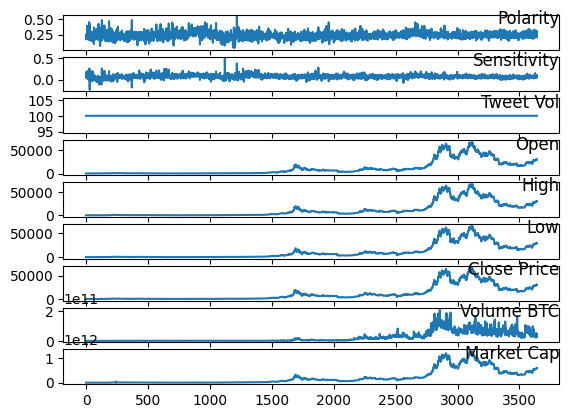

In [121]:
# Plotting the data inside the DataFrame
values = final_df.values
groups = [0,1,2,3,4,5,6,7,8]
i = 1  
pyplot.figure()
for group in groups:
    pyplot.subplot(len(groups), 1, i)
    pyplot.plot(values[:, group])
    pyplot.title(final_df.columns[group], y=.5, loc='right')
    i += 1
pyplot.show()

In [122]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3642 entries, 2013-04-28 to 2023-04-17
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Polarity     3642 non-null   float64
 1   Sensitivity  3642 non-null   float64
 2   Tweet Vol    3642 non-null   float64
 3   Open         3642 non-null   float64
 4   High         3642 non-null   float64
 5   Low          3642 non-null   float64
 6   Close Price  3642 non-null   float64
 7   Volume BTC   3642 non-null   float64
 8   Market Cap   3642 non-null   float64
 9   RSI          3642 non-null   float64
 10  SMA          3642 non-null   float64
dtypes: float64(11)
memory usage: 470.5 KB


In [123]:
cor = final_df.corr()
cor

,Polarity,Sensitivity,Tweet Vol,Open,High,Low,Close Price,Volume BTC,Market Cap,RSI,SMA
Polarity,1.000000,0.333738,NaN,0.019144,0.018780,0.019750,0.019276,0.057846,0.021850,0.019455,0.019457
Sensitivity,0.333738,1.000000,NaN,-0.075841,-0.076508,-0.075718,-0.076205,-0.074470,-0.075552,0.017098,-0.075127
Tweet Vol,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Open,0.019144,-0.075841,NaN,1.000000,0.999536,0.999226,0.998896,0.878440,0.999389,-0.059657,0.997216
High,0.018780,-0.076508,NaN,0.999536,1.000000,0.999112,0.999506,0.880612,0.999433,-0.053715,0.997841
Low,0.019750,-0.075718,NaN,0.999226,0.999112,1.000000,0.999441,0.873885,0.999591,-0.053608,0.997738
Close Price,0.019276,-0.076205,NaN,0.998896,0.999506,0.999441,1.000000,0.877589,0.999361,-0.048493,0.998321
Volume BTC,0.057846,-0.074470,NaN,0.878440,0.880612,0.873885,0.877589,1.000000,0.879622,-0.036037,0.876645
Market Cap,0.021850,-0.075552,NaN,0.999389,0.999433,0.999591,0.999361,0.879622,1.000000,-0.053512,0.997665
RSI,0.019455,0.017098,NaN,-0.059657,-0.053715,-0.053608,-0.048493,-0.036037,-0.053512,1.000000,-0.026531


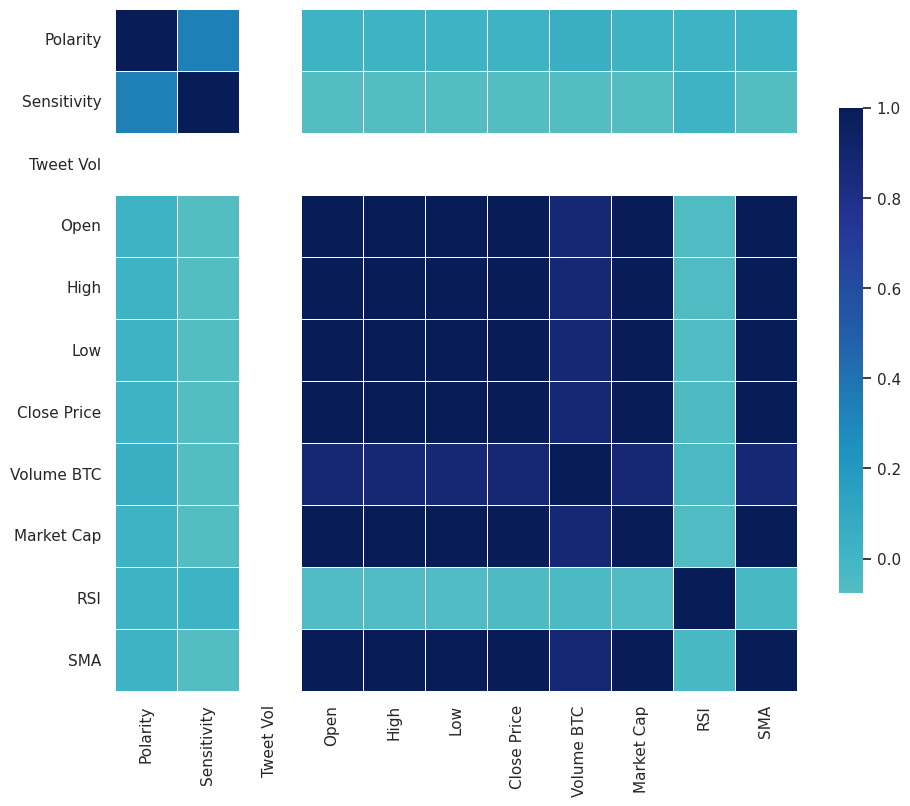

In [124]:
sns.set(style="white")
f, ax = pyplot.subplots(figsize=(11, 9))

ax = sns.heatmap(cor, cmap="YlGnBu", vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .7})
pyplot.show()

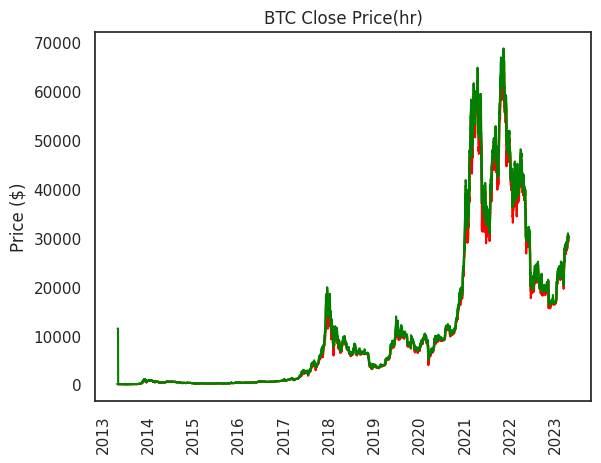

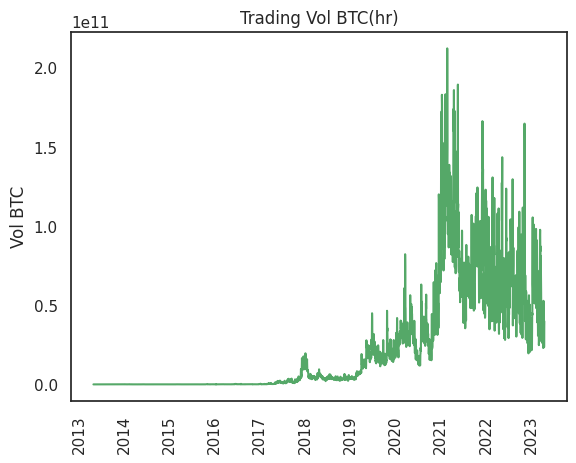

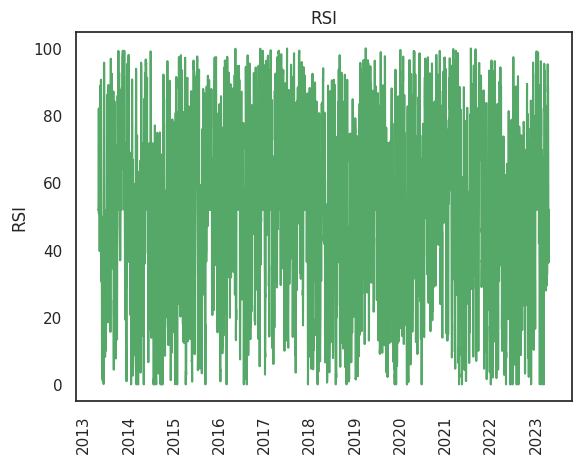

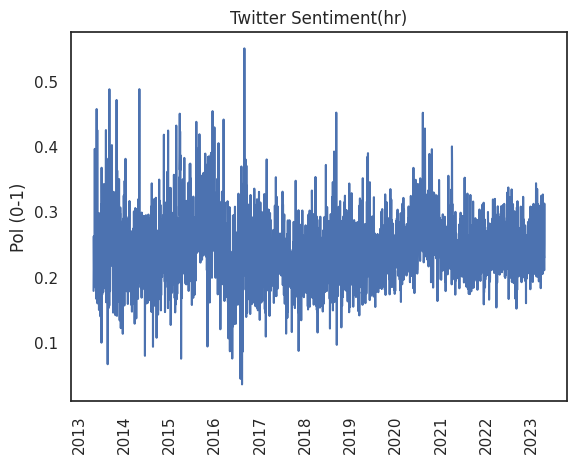

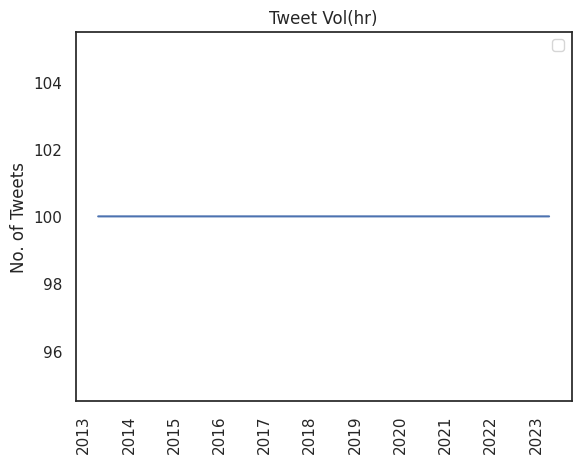

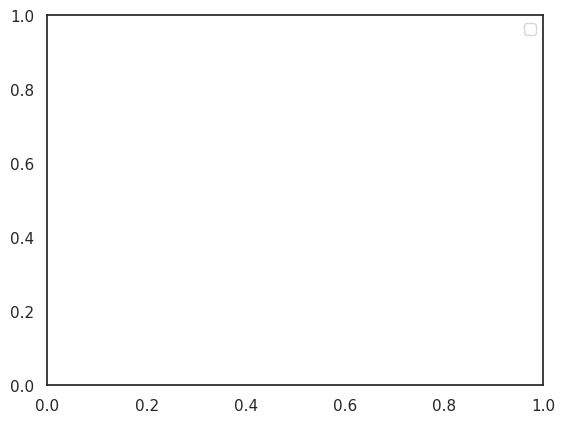

In [125]:
plt.plot(final_df.index, final_df['Close Price'], 'black')
plt.plot(final_df.index, final_df['Open'], 'yellow')
plt.plot(final_df.index, final_df['Low'], 'red')
plt.plot(final_df.index, final_df['High'], 'green')
plt.plot(final_df.index, final_df['SMA'], 'green')
plt.title('BTC Close Price(hr)')
plt.xticks(rotation ='vertical')
plt.ylabel('Price ($)');
plt.show();

plt.plot(final_df.index, final_df['Volume BTC'], 'g')
plt.title('Trading Vol BTC(hr)')
plt.xticks(rotation ='vertical')
plt.ylabel('Vol BTC');
plt.show();

plt.plot(final_df.index, final_df['RSI'], 'g')
plt.title('RSI')
plt.xticks(rotation = 'vertical')
plt.ylabel('RSI');
plt.show();

plt.plot(final_df.index, final_df['Polarity'], 'b')
plt.xticks(rotation = 'vertical')
plt.title('Twitter Sentiment(hr)')
plt.ylabel('Pol (0-1)');
plt.show();
plt.legend()

plt.plot(final_df.index, final_df['Tweet Vol'], 'b')
plt.xticks(rotation = 'vertical')
plt.title('Tweet Vol(hr)')
plt.ylabel('No. of Tweets');
plt.show();
plt.legend()

In [126]:
date_time_df = final_df.copy()

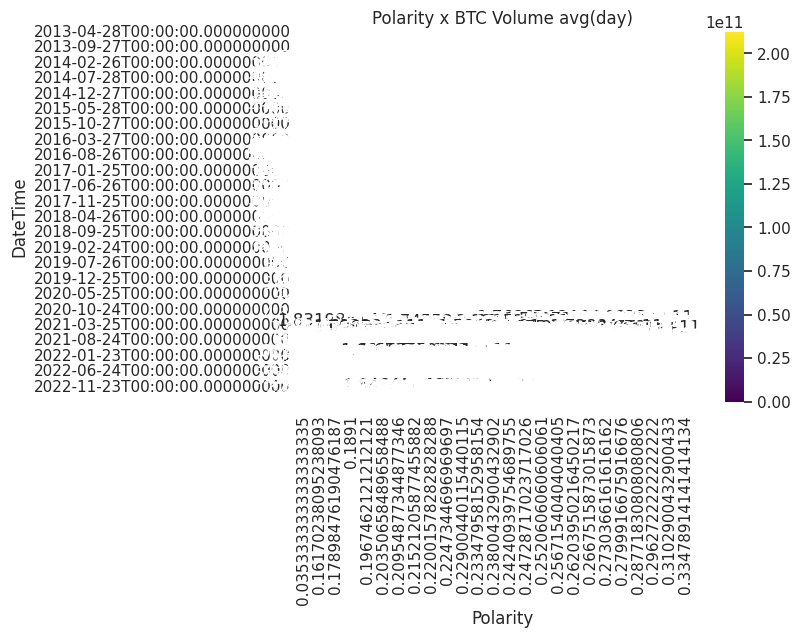

In [127]:
date_time_df['DateTime'] = final_df.index
result = date_time_df.pivot(index='DateTime', columns='Polarity', values='Volume BTC')
sns.heatmap(result, annot=True, fmt="g", cmap='viridis')
plt.title('Polarity x BTC Volume avg(day)')
plt.show()

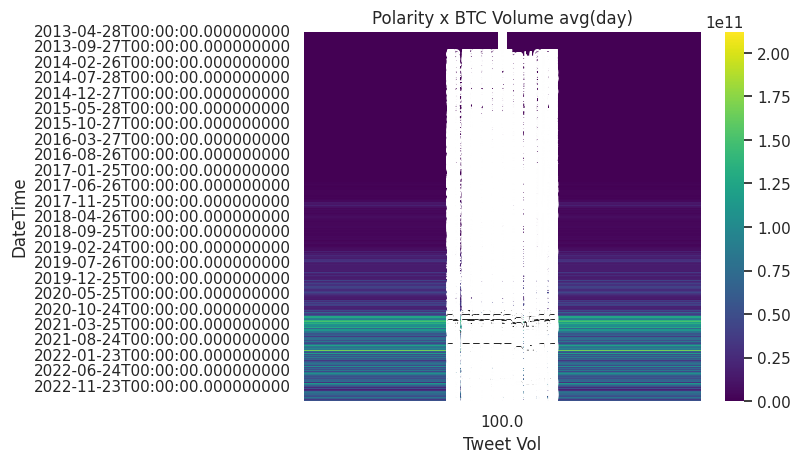

In [128]:
date_time_df['DateTime'] = final_df.index
result = date_time_df.pivot(index='DateTime', columns='Tweet Vol', values='Volume BTC')
sns.heatmap(result, annot=True, fmt="g", cmap='viridis')
plt.title('Polarity x BTC Volume avg(day)')
plt.show()

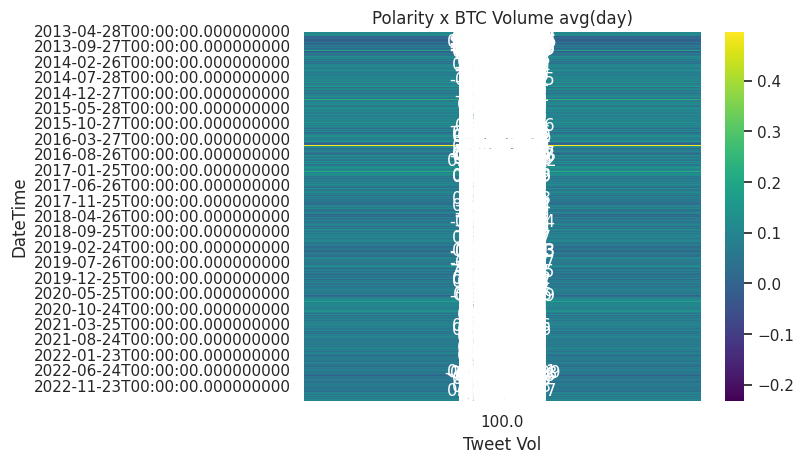

In [129]:
date_time_df['DateTime'] = final_df.index
result = date_time_df.pivot(index='DateTime', columns='Tweet Vol', values='Sensitivity')
sns.heatmap(result, annot=True, fmt="g", cmap='viridis')
plt.title('Polarity x BTC Volume avg(day)')
plt.show()

# Prepraration for the model

In [323]:
df = final_df.copy()
df = df.drop(['Open', 'High', 'Low', 'Market Cap'], axis=1)
df.head()

,Polarity,Sensitivity,Tweet Vol,Close Price,Volume BTC,RSI,SMA
DateTime,,,,,,,
2013-04-28,0.178547,0.048872,100.0,144.54,0.0,51.934984,11486.951152
2013-04-29,0.225538,0.172470,100.0,139.00,0.0,51.934984,11486.951152
2013-04-30,0.262298,0.136439,100.0,116.99,0.0,51.934984,11486.951152
2013-05-01,0.232694,0.059392,100.0,105.21,0.0,51.934984,11486.951152
2013-05-02,0.213571,0.107710,100.0,97.75,0.0,51.934984,11486.951152


In [324]:
df = df[['Close Price', 'Polarity', 'Sensitivity','Tweet Vol', 'Volume BTC']]
df.head()

,Close Price,Polarity,Sensitivity,Tweet Vol,Volume BTC
DateTime,,,,,
2013-04-28,144.54,0.178547,0.048872,100.0,0.0
2013-04-29,139.00,0.225538,0.172470,100.0,0.0
2013-04-30,116.99,0.262298,0.136439,100.0,0.0
2013-05-01,105.21,0.232694,0.059392,100.0,0.0
2013-05-02,97.75,0.213571,0.107710,100.0,0.0


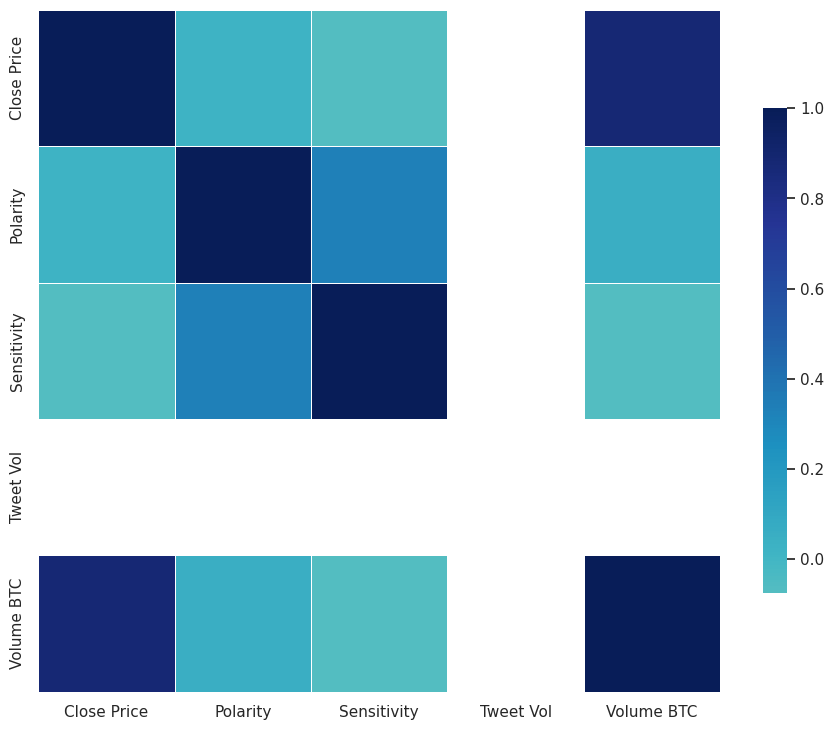

In [325]:
cor = df.corr()
sns.set(style="white")
f, ax = plt.subplots(figsize=(11, 9))

ax =sns.heatmap(cor, cmap="YlGnBu", vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .7})
plt.show()

In [326]:
# Convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# Input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# Forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# Put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# Drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [327]:
df.tail()

,Close Price,Polarity,Sensitivity,Tweet Vol,Volume BTC
DateTime,,,,,
2023-04-13,30478.29240,0.233711,0.078786,100.0,4.807126e+10
2023-04-14,30297.83114,0.229004,0.048508,100.0,3.682381e+10
2023-04-15,30304.87458,0.250280,0.043739,100.0,2.347144e+10
2023-04-16,29413.96000,0.312370,0.110012,100.0,3.454499e+10
2023-04-17,30366.57000,0.210686,0.102754,100.0,3.984320e+10


In [328]:
values = df.values
cols = df.columns.tolist()
cols = cols[-1:] + cols[:-1]
df = df[cols]
df = df[['Close Price', 'Polarity', 'Sensitivity', 'Tweet Vol', 'Volume BTC']]
df.head()

,Close Price,Polarity,Sensitivity,Tweet Vol,Volume BTC
DateTime,,,,,
2013-04-28,144.54,0.178547,0.048872,100.0,0.0
2013-04-29,139.00,0.225538,0.172470,100.0,0.0
2013-04-30,116.99,0.262298,0.136439,100.0,0.0
2013-05-01,105.21,0.232694,0.059392,100.0,0.0
2013-05-02,97.75,0.213571,0.107710,100.0,0.0


In [329]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(df.values)

## Creating the Hyperparameters

In [340]:
N_DAYS = 1 # Adding 3 days lags creating number of observations 
N_FEATURES = 5 # Features in the dataset.
N_OBS = N_DAYS * N_FEATURES

## Creating the training and test data

In [341]:
reframed = series_to_supervised(scaled, N_DAYS, 1)
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var1(t),var2(t),var3(t),var4(t),var5(t)
1,0.001129,0.278187,0.386116,0.0,0.0,0.001047,0.369467,0.555464,0.0,0.0
2,0.001047,0.369467,0.555464,0.0,0.0,0.000720,0.440872,0.506097,0.0,0.0
3,0.000720,0.440872,0.506097,0.0,0.0,0.000545,0.383368,0.400529,0.0,0.0
4,0.000545,0.383368,0.400529,0.0,0.0,0.000435,0.346221,0.466732,0.0,0.0
5,0.000435,0.346221,0.466732,0.0,0.0,0.000654,0.341541,0.453362,0.0,0.0


In [342]:
reframed.tail()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var1(t),var2(t),var3(t),var4(t),var5(t)
3637,0.449213,0.492864,0.411860,0.0,0.202205,0.450973,0.385343,0.427103,0.0,0.226589
3638,0.450973,0.385343,0.427103,0.0,0.226589,0.448297,0.376200,0.385617,0.0,0.173573
3639,0.448297,0.376200,0.385617,0.0,0.173573,0.448402,0.417528,0.379083,0.0,0.110635
3640,0.448402,0.417528,0.379083,0.0,0.110635,0.435190,0.538135,0.469887,0.0,0.162831
3641,0.435190,0.538135,0.469887,0.0,0.162831,0.449317,0.340618,0.459942,0.0,0.187805


In [343]:
reframed.values

array([[0.00112868, 0.27818736, 0.38611621, ..., 0.55546375, 0.        ,
        0.        ],
       [0.00104653, 0.36946664, 0.55546375, ..., 0.50609667, 0.        ,
        0.        ],
       [0.00072012, 0.44087204, 0.50609667, ..., 0.40052938, 0.        ,
        0.        ],
       ...,
       [0.44829728, 0.37620026, 0.38561723, ..., 0.37908298, 0.        ,
        0.11063501],
       [0.44840173, 0.41752788, 0.37908298, ..., 0.46988722, 0.        ,
        0.16283132],
       [0.43518961, 0.53813485, 0.46988722, ..., 0.45994184, 0.        ,
        0.18780495]])

In [344]:
values = reframed.values
reframed.shape[0]
N_TRAIN = round(reframed.shape[0] * 0.90)
train = values[:N_TRAIN, :]
test = values[N_TRAIN:, :]
train.shape, test.shape

((3277, 10), (364, 10))

In [345]:
# Split into input and outputs
train_X, train_y = train[:, :N_OBS], train[:, -N_FEATURES]
test_X, test_y = test[:, :N_OBS], test[:, -N_FEATURES]

In [346]:
# Reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], N_DAYS, N_FEATURES))
test_X = test_X.reshape((test_X.shape[0], N_DAYS, N_FEATURES))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(3277, 1, 5) (3277,) (364, 1, 5) (364,)


## Creating the model

In [347]:
# Setting the random seed
tf.random.set_seed(42)

# Creating the model
model = Sequential([
    LSTM(5, input_shape=(train_X.shape[1], train_X.shape[2])),
    Dense(1)
])

# Compile the model
model.compile(
    loss = 'mae',
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ['accuracy']
    )

# Fit the model
history = model.fit(
    train_X,
    train_y,
    epochs = 10,
    batch_size = 6,
    validation_data = (test_X, test_y),
    verbose = 1
    )

Epoch 1/10
547/547 [==============================] - 5s 5ms/step - loss: 0.0990 - accuracy: 3.0516e-04 - val_loss: 0.0518 - val_accuracy: 0.0000e+00
Epoch 2/10
547/547 [==============================] - 2s 4ms/step - loss: 0.0179 - accuracy: 6.1031e-04 - val_loss: 0.0418 - val_accuracy: 0.0000e+00
Epoch 3/10
547/547 [==============================] - 2s 3ms/step - loss: 0.0088 - accuracy: 6.1031e-04 - val_loss: 0.0129 - val_accuracy: 0.0000e+00
Epoch 4/10
547/547 [==============================] - 2s 3ms/step - loss: 0.0063 - accuracy: 6.1031e-04 - val_loss: 0.0109 - val_accuracy: 0.0000e+00
Epoch 5/10
547/547 [==============================] - 2s 3ms/step - loss: 0.0060 - accuracy: 6.1031e-04 - val_loss: 0.0096 - val_accuracy: 0.0000e+00
Epoch 6/10
547/547 [==============================] - 2s 3ms/step - loss: 0.0059 - accuracy: 6.1031e-04 - val_loss: 0.0146 - val_accuracy: 0.0000e+00
Epoch 7/10
547/547 [==============================] - 2s 3ms/step - loss: 0.0057 - accuracy: 6.1031e

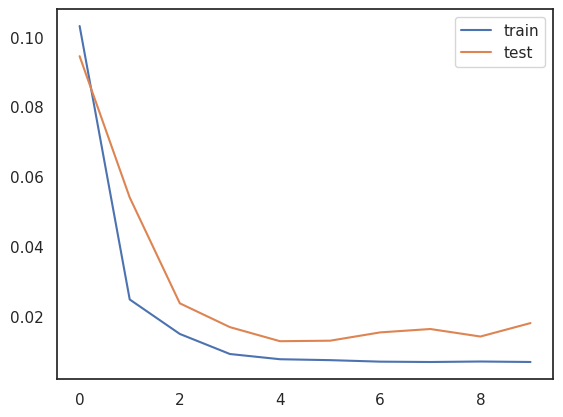

In [338]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [339]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], N_DAYS * N_FEATURES,))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, -4:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -4:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
mse = (mean_squared_error(inv_y, inv_yhat))
print('Test MSE: %.3f' % mse)
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

12/12 [==============================] - 49s 2ms/step
Test MSE: 2367890.872
Test RMSE: 1538.795
